DATA COLECTION && PREPEROCESSING


In [2]:
import json
import pandas as pd


json_files = ['1.json', '2.json', '3.json']

# Supported transaction types
activity_types = ['deposits', 'borrows', 'repays', 'withdraws', 'liquidates']

# Collect all transactions
all_txns = []

for file in json_files:
    with open(file) as f:
        data = json.load(f)

    for tx_type in activity_types:
        for txn in data.get(tx_type, []):
            flat_txn = {
                'wallet': txn['account']['id'],
                'amount': float(txn['amount']),
                'amountUSD': float(txn['amountUSD']),
                'token': txn['asset']['symbol'],
                'hash': txn['hash'],
                'timestamp': int(txn['timestamp']),
                'txn_type': tx_type,
                'source_file': file  
            }
            all_txns.append(flat_txn)


df = pd.DataFrame(all_txns) #  combined DataFrame

# Convert timestamps
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Preview
print(df.head(2))
print(f"\nTotal records loaded: {len(df)}")


                                       wallet        amount   amountUSD token  \
0  0x013022c7ca735ef6ba55cd3eaccb4ebb3be484e9  2.779531e+20  277.910844   DAI   
1  0x8888882f8f843896699869179fb6e4f7e3b58888  2.621678e+20  262.127907   DAI   

                                                hash   timestamp  txn_type  \
0  0x3b234517a906639157334a9e4a64ce9c74479aeb5572...  1712140379  deposits   
1  0x3b234517a906639157334a9e4a64ce9c74479aeb5572...  1712140379  deposits   

  source_file            datetime  
0      1.json 2024-04-03 10:32:59  
1      1.json 2024-04-03 10:32:59  

Total records loaded: 29305


In [3]:
print(df.isnull().sum())  # See if any columns have missing data
print(df['txn_type'].value_counts())  # Confirm all expected actions are present

wallet         0
amount         0
amountUSD      0
token          0
hash           0
timestamp      0
txn_type       0
source_file    0
datetime       0
dtype: int64
txn_type
deposits    29305
Name: count, dtype: int64


FEATURE ENGINEERING

In [4]:
#To transform raw, transaction-level data into meaningful, wallet-level behavioral features 
# that reflect financial responsibility, risk, and engagement — required for scoring and tiering wallets in DeFi.
import numpy as np

#  Group by wallet and txn_type -> count and sum of amountUSD
grouped = df.groupby(['wallet', 'txn_type'])['amountUSD'].agg(['count', 'sum']).unstack(fill_value=0)
grouped.columns = [f"{stat}_{tx_type}" for stat, tx_type in grouped.columns]
wallet_stats = grouped.reset_index()

# Extract values or fallback to zeros
deposits = np.array(wallet_stats.get('sum_deposits', 0))
withdraws = np.array(wallet_stats.get('sum_withdraws', 0))
borrows = np.array(wallet_stats.get('sum_borrows', 0))
repays = np.array(wallet_stats.get('sum_repays', 0))
liq_count = np.array(wallet_stats.get('count_liquidates', 0))
borrow_count = np.array(wallet_stats.get('count_borrows', 0))

# Derived features with safe division
wallet_stats['repay_to_borrow_ratio'] = np.divide(
    repays, borrows, out=np.zeros_like(repays, dtype=float), where=borrows != 0
)

wallet_stats['net_flow_usd'] = deposits - withdraws

wallet_stats['liquidation_ratio'] = np.divide(
    liq_count, borrow_count, out=np.zeros_like(liq_count, dtype=float), where=borrow_count != 0
)


# Token diversity
token_diversity = df.groupby('wallet')['token'].nunique().reset_index(name='token_diversity')
wallet_stats = wallet_stats.merge(token_diversity, on='wallet', how='left')

# Time-based features
time_stats = df.groupby('wallet')['datetime'].agg(['min', 'max']).reset_index()
time_stats['active_days'] = (time_stats['max'] - time_stats['min']).dt.days + 1
wallet_stats = wallet_stats.merge(time_stats[['wallet', 'active_days']], on='wallet', how='left')


print(wallet_stats.head(1))
#These features  that in the wallet_stats are the foundation for credit scoring logic in my view

                                       wallet  count_deposits  sum_deposits  \
0  0x00000000000747d525e898424e8774f7eb317d00             288  1.021574e+07   

   repay_to_borrow_ratio  net_flow_usd  liquidation_ratio  token_diversity  \
0                    0.0  1.021574e+07                0.0                2   

   active_days  
0          417  


CREDIT SCORING

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant features
features = ['repay_to_borrow_ratio', 'liquidation_ratio', 'net_flow_usd', 'token_diversity', 'active_days']

# Fill missing values (e.g., NaN from missing activity)
wallet_stats[features] = wallet_stats[features].fillna(0)

# Normalize features to 0–1
scaler = MinMaxScaler()
wallet_stats_scaled = scaler.fit_transform(wallet_stats[features])
wallet_stats_scaled = pd.DataFrame(wallet_stats_scaled, columns=features)

# Assign weights to features (tweak as needed)
weights = {
    'repay_to_borrow_ratio': 0.3,
    'liquidation_ratio': -0.2,      # negative weight: lower is better
    'net_flow_usd': 0.25,
    'token_diversity': 0.15,
    'active_days': 0.1
}

# Apply weighted sum
credit_score = (
    wallet_stats_scaled['repay_to_borrow_ratio'] * weights['repay_to_borrow_ratio'] +
    wallet_stats_scaled['liquidation_ratio'] * weights['liquidation_ratio'] +
    wallet_stats_scaled['net_flow_usd'] * weights['net_flow_usd'] +
    wallet_stats_scaled['token_diversity'] * weights['token_diversity'] +
    wallet_stats_scaled['active_days'] * weights['active_days']
)

# Rescale to 0–100
wallet_stats['credit_score'] = (credit_score - credit_score.min()) / (credit_score.max() - credit_score.min()) * 100

# Preview final result
final_output = wallet_stats[['wallet', 'credit_score'] + features]
print(final_output.sort_values(by='credit_score', ascending=False).head(5))



                                          wallet  credit_score  \
4299  0xab50dd1c57938218627df2311ef65b4e2e84af48    100.000000   
4637  0xb99cc7e10fe0acc68c50c7829f473d81e23249cc     89.574190   
5203  0xd275e5cb559d6dc236a5f8002a5f0b4c8e610701     80.394382   
5254  0xd4bb298f935cdfa7eb5e363d168f838bb65cdff4     79.652512   
355   0x0f1dfef1a40557d279d0de6e49ab306891a638b8     78.043025   

      repay_to_borrow_ratio  liquidation_ratio  net_flow_usd  token_diversity  \
4299                    0.0                0.0  1.932268e+09                2   
4637                    0.0                0.0  6.631948e+08                5   
5203                    0.0                0.0  1.118951e+09                4   
5254                    0.0                0.0  1.262840e+09                3   
355                     0.0                0.0  1.024145e+09                4   

      active_days  
4299           38  
4637          790  
5203          238  
5254          183  
355           28

In [6]:
final_output.sort_values(by='credit_score', ascending=False).to_csv('top_wallet_scores.csv', index=False)
#storig top-wallet scores in csv file


Elbow Method -to decide the optimal number of clusters

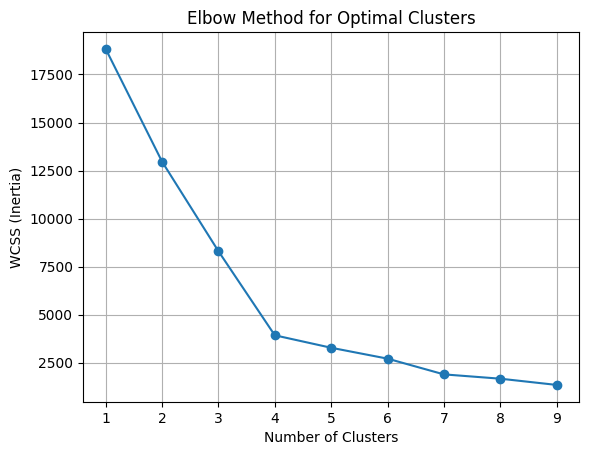

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select features to cluster on
features_for_clustering = ['repay_to_borrow_ratio', 'liquidation_ratio', 'net_flow_usd', 'token_diversity', 'active_days']
X = final_output[features_for_clustering].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters (optional elbow method)
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()


In [8]:
# Apply k means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') 
final_output['credit_tier'] = kmeans.fit_predict(X_scaled)





C:\Users\viju1\AppData\Local\Temp\ipykernel_3672\3849083839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_output['credit_tier'] = kmeans.fit_predict(X_scaled)


In [9]:
# Rank tiers based on average credit score
tier_ranking = final_output.groupby('credit_tier')['credit_score'].mean().sort_values(ascending=False)
tier_map = {cluster: f'Tier {i+1}' for i, cluster in enumerate(tier_ranking.index)}

# Apply readable labels
final_output['credit_tier'] = final_output['credit_tier'].map(tier_map)


C:\Users\viju1\AppData\Local\Temp\ipykernel_3672\1939976242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_output['credit_tier'] = final_output['credit_tier'].map(tier_map)


In [10]:
# Export top 1000 values to csv
final_output.sort_values(by='credit_score', ascending=False).head(1000).to_csv('top_1000_wallets.csv', index=False)

# Export all wallets with credit scores and tiers
final_output.to_csv('wallet_credit_scores.csv', index=False)


In [11]:
hff = pd.read_csv('top_wallet_scores.csv')
hff1=pd.read_csv('top_1000_wallets.csv')
hff2=pd.read_csv('wallet_credit_scores.csv')

In [12]:
hff1.head(5)


,wallet,credit_score,repay_to_borrow_ratio,liquidation_ratio,net_flow_usd,token_diversity,active_days,credit_tier
0,0xab50dd1c57938218627df2311ef65b4e2e84af48,100.000000,0.0,0.0,1.932268e+09,2,38,Tier 1
1,0xb99cc7e10fe0acc68c50c7829f473d81e23249cc,89.574190,0.0,0.0,6.631948e+08,5,790,Tier 1
2,0xd275e5cb559d6dc236a5f8002a5f0b4c8e610701,80.394382,0.0,0.0,1.118951e+09,4,238,Tier 1
3,0xd4bb298f935cdfa7eb5e363d168f838bb65cdff4,79.652512,0.0,0.0,1.262840e+09,3,183,Tier 1
4,0x0f1dfef1a40557d279d0de6e49ab306891a638b8,78.043025,0.0,0.0,1.024145e+09,4,285,Tier 1


In [13]:
hff1.tail(5)

,wallet,credit_score,repay_to_borrow_ratio,liquidation_ratio,net_flow_usd,token_diversity,active_days,credit_tier
995,0x3f3429d28438cc14133966820b8a9ea61cf1d4f0,8.436126,0.0,0.0,4.662958e+07,1,132,Tier 4
996,0xbabe777e1a43053c273bd8a4e45d0cb6c20f8fc6,8.420840,0.0,0.0,2.711933e+05,1,179,Tier 4
997,0xc4741e354a6eb520fc222b9f4c69ad07d6beaa23,8.407781,0.0,0.0,3.593176e+02,1,179,Tier 4
998,0x06f522a84e0101545516b149ccc4e5561608da1d,8.406412,0.0,0.0,3.727135e+05,2,71,Tier 4
999,0xeb312f4921aebbe99facacfe92f22b942cbd7599,8.357894,0.0,0.0,3.461091e+05,2,70,Tier 4


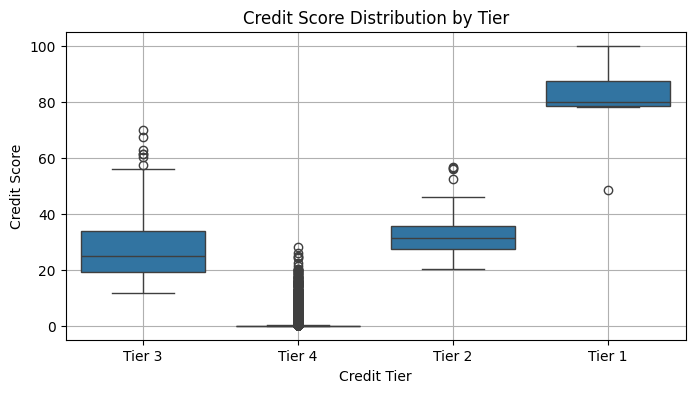

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.boxplot(data=final_output, x='credit_tier', y='credit_score')
plt.title("Credit Score Distribution by Tier")
plt.ylabel("Credit Score")
plt.xlabel("Credit Tier")
plt.grid(True)
plt.show()


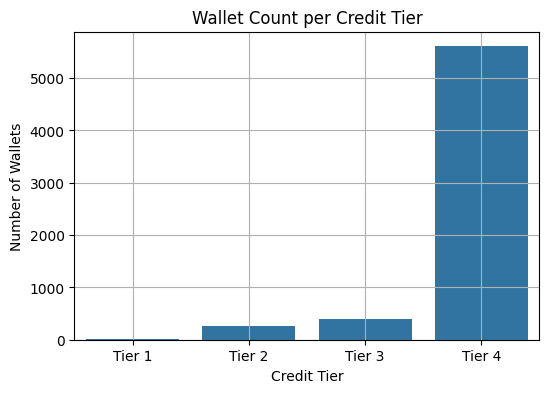

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data=final_output, x='credit_tier', order=sorted(final_output['credit_tier'].unique()))
plt.title("Wallet Count per Credit Tier")
plt.xlabel("Credit Tier")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


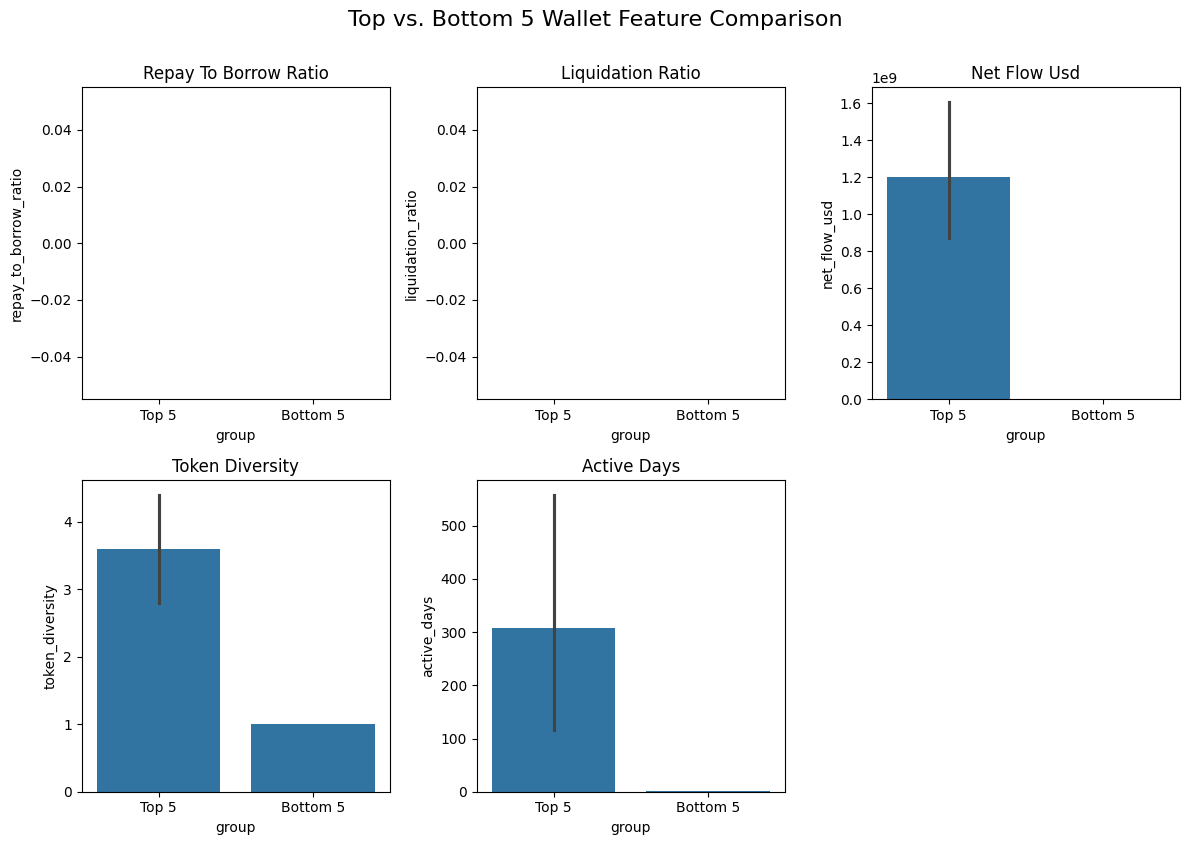

In [16]:
top_5 = final_output.sort_values(by='credit_score', ascending=False).head(5)
bottom_5 = final_output.sort_values(by='credit_score', ascending=True).head(5)

combined = pd.concat([top_5.assign(group='Top 5'), bottom_5.assign(group='Bottom 5')])

features = ['repay_to_borrow_ratio', 'liquidation_ratio', 'net_flow_usd', 'token_diversity', 'active_days']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=combined, x='group', y=feature)
    plt.title(feature.replace('_', ' ').title())
    plt.tight_layout()
plt.suptitle("Top vs. Bottom 5 Wallet Feature Comparison", fontsize=16, y=1.05)
plt.show()
